#**Liquidation-Strategy-Analysis-using-**
#**Multi-Agent-Deep-Reinforcement-Learning**

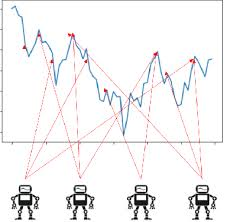

In [ ]:
#Start running each cell step by step( Note : After downgrading Version 
# tensorflow and numpy restart runtime, It is also mentioned below the code where these versions
# are downgraded)


In [ ]:
!pip install --upgrade numpy==1.14.5
#Then go to the runtime and click on restrat runtime

     |████████████████████████████████| 12.2MB 313kB/s 
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: spacy 2.1.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: fastai 1.0.60 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.25 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: astropy 4.0 has requirement numpy>=1.16, but you'll have numpy 1.14.5 which is incompatible.
ERROR: a

In [ ]:
import numpy
numpy.version.version

'1.14.5'

In [ ]:
!pip install tensorflow==1.12.0
#then go to runtime and click on restrat runtime

     |████████████████████████████████| 83.1MB 100kB/s 
     |████████████████████████████████| 3.1MB 31.8MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [ ]:

import tensorflow as tf
print(tf.__version__)

1.12.0


# **Synthetic Almgren Chriss model**

In [ ]:
import random
import numpy as np
import collections


# ------------------------------------------------ Financial Parameters --------------------------------------------------- #

ANNUAL_VOLAT = 0.12                                # Annual volatility in stock price
BID_ASK_SP = 1 / 8                                 # Bid-ask spread
DAILY_TRADE_VOL = 5e6                              # Average Daily trading volume  
TRAD_DAYS = 250                                    # Number of trading days in a year
DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(TRAD_DAYS)    # Daily volatility in stock price


# ----------------------------- Parameters for the Almgren and Chriss Optimal Execution Model ----------------------------- #

TOTAL_SHARES1 = 500000                                               # Total number of shares to sell
TOTAL_SHARES2 = 500000                                               # Total number of shares to sell
STARTING_PRICE = 50                                                  # Starting price per share
LLAMBDA1 = 1e-6                                                       # Trader's risk aversion
LLAMBDA2 = 1e-4
LIQUIDATION_TIME = 60                                                # How many days to sell all the shares. 
NUM_N = 60                                                           # Number of trades
EPSILON = BID_ASK_SP / 2                                             # Fixed Cost of Selling.
SINGLE_STEP_VARIANCE = (DAILY_VOLAT  * STARTING_PRICE) ** 2          # Calculate single step variance
ETA = BID_ASK_SP / (0.01 * DAILY_TRADE_VOL)                          # Price Impact for Each 1% of Daily Volume Traded
GAMMA = BID_ASK_SP / (0.1 * DAILY_TRADE_VOL)                         # Permanent Impact Constant

# ----------------------------------------------------------------------------------------------------------------------- #


# Simulation Environment

class MarketEnvironment():
    
    def __init__(self, randomSeed = 0,
                 lqd_time = LIQUIDATION_TIME,
                 num_tr = NUM_N,
                 lambd1 = LLAMBDA1,
                 lambd2 = LLAMBDA2):
        
        # Set the random seed
        random.seed(randomSeed)
        
        # Initialize the financial parameters so we can access them later
        self.anv = ANNUAL_VOLAT
        self.basp = BID_ASK_SP
        self.dtv = DAILY_TRADE_VOL
        self.dpv = DAILY_VOLAT
        
        # Initialize the Almgren-Chriss parameters so we can access them later
        self.total_shares1 = TOTAL_SHARES1
        self.total_shares2 = TOTAL_SHARES2
        self.startingPrice = STARTING_PRICE
        self.llambda1 = lambd1
        self.llambda2 = lambd2
        self.liquidation_time = lqd_time
        self.num_n = num_tr
        self.epsilon = EPSILON
        self.singleStepVariance = SINGLE_STEP_VARIANCE
        self.eta = ETA
        self.gamma = GAMMA
        
        # Calculate some Almgren-Chriss parameters
        self.tau = self.liquidation_time / self.num_n 
        self.eta_hat = self.eta - (0.5 * self.gamma * self.tau)
        self.kappa_hat1 = np.sqrt((self.llambda1 * self.singleStepVariance) / self.eta_hat)
        self.kappa_hat2 = np.sqrt((self.llambda2 * self.singleStepVariance) / self.eta_hat)
        self.kappa1 = np.arccosh((((self.kappa_hat1 ** 2) * (self.tau ** 2)) / 2) + 1) / self.tau
        self.kappa2 = np.arccosh((((self.kappa_hat2 ** 2) * (self.tau ** 2)) / 2) + 1) / self.tau

        # Set the variables for the initial state
        self.shares_remaining1 = self.total_shares1
        self.shares_remaining2 = self.total_shares2
        self.timeHorizon = self.num_n
        self.logReturns = collections.deque(np.zeros(6))
        
        # Set the initial impacted price to the starting price
        self.prevImpactedPrice = self.startingPrice

        # Set the initial transaction state to False
        self.transacting1 = False
        self.transacting2 = False
        
        # Set a variable to keep trak of the trade number
        self.k = 0
        
        
    def reset(self, seed = 0, liquid_time = LIQUIDATION_TIME, num_trades = NUM_N, lamb1 = LLAMBDA1,lamb2 = LLAMBDA2):
        
        # Initialize the environment with the given parameters
        self.__init__(randomSeed = seed, lqd_time = liquid_time, num_tr = num_trades, lambd1 = lamb1,lambd2 = lamb2)
        
        # Set the initial state to [0,0,0,0,0,0,1,1]
        self.initial_state = np.array(list(self.logReturns) + [self.timeHorizon / self.num_n, \
                                                               self.shares_remaining1 / self.total_shares1, \
                                                               self.shares_remaining2 / self.total_shares2])
        return self.initial_state

    
    def start_transactions(self):
        
        # Set transactions on
        self.transacting1 = True
        self.transacting2 = True
        
        # Set the minimum number of stocks one can sell
        self.tolerance = 1
        
        # Set the initial capture to zero
        self.totalCapture1 = 0
        self.totalCapture2 = 0
        
        # Set the initial previous price to the starting price
        self.prevPrice = self.startingPrice
        
        # Set the initial square of the shares to sell to zero
        self.totalSSSQ1 = 0
        self.totalSSSQ2 = 0
        # Set the initial square of the remaing shares to sell to zero
        self.totalSRSQ1 = 0
        self.totalSRSQ2 = 0
        # Set the initial AC utility
        self.prevUtility1 = self.compute_AC_utility(self.total_shares1,self.kappa1,self.llambda1)
        self.prevUtility2 = self.compute_AC_utility(self.total_shares2,self.kappa2,self.llambda2)

    def step(self, action1,action2):
        
        # Create a class that will be used to keep track of information about the transaction
        class Info(object):
            pass        
        info = Info()
        
        # Set the done flag to False. This indicates that we haven't sold all the shares yet.
        info.done1 = False
        info.done2 = False
                
        # During training, if the DDPG fails to sell all the stocks before the given 
        # number of trades or if the total number shares remaining is less than 1, then stop transacting,
        # set the done Flag to True, return the current implementation shortfall, and give a negative reward.
        # The negative reward is given in the else statement below.
        if self.transacting1 and (self.timeHorizon == 0 or (abs(self.shares_remaining1) < self.tolerance)):
            self.transacting1 = False
            info.done1 = True
            info.implementation_shortfall1 = self.total_shares1 * self.startingPrice - self.totalCapture1
            info.expected_shortfall1 = self.get_expected_shortfall(self.total_shares1,self.totalSSSQ1)
            info.expected_variance1 = self.singleStepVariance * self.tau * self.totalSRSQ1
            info.utility1 = info.expected_shortfall1 + self.llambda1 * info.expected_variance1
        
        if self.transacting2 and (self.timeHorizon == 0 or (abs(self.shares_remaining2) < self.tolerance)):
            self.transacting2 = False
            info.done2 = True
            info.implementation_shortfall2 = self.total_shares2 * self.startingPrice - self.totalCapture2
            info.expected_shortfall2 = self.get_expected_shortfall(self.total_shares2,self.totalSSSQ2)
            info.expected_variance2 = self.singleStepVariance * self.tau * self.totalSRSQ2
            info.utility2 = info.expected_shortfall2 + self.llambda2 * info.expected_variance2

        # We don't add noise before the first trade    
        if self.k == 0:
            info.price = self.prevImpactedPrice
        else:
            # Calculate the current stock price using arithmetic brownian motion
            info.price = self.prevImpactedPrice + np.sqrt(self.singleStepVariance * self.tau) * random.normalvariate(0, 1)
      
        # If we are transacting, the stock price is affected by the number of shares we sell. The price evolves 
        # according to the Almgren and Chriss price dynamics model. 
        if self.transacting1:
            
            # If action is an ndarray then extract the number from the array
            if isinstance(action1, np.ndarray):
                action1 = action1.item()             

            # Convert the action to the number of shares to sell in the current step
            sharesToSellNow1 = self.shares_remaining1 * action1

            if self.timeHorizon < 2:
                sharesToSellNow1 = self.shares_remaining1
        else: 
            sharesToSellNow1 = 0
#             sharesToSellNow = min(self.shares_remaining * action, self.shares_remaining)
        if self.transacting2:
            
            # If action is an ndarray then extract the number from the array
            if isinstance(action2, np.ndarray):
                action2 = action2.item()             

            # Convert the action to the number of shares to sell in the current step
            sharesToSellNow2 = self.shares_remaining2 * action2

            if self.timeHorizon < 2:
                sharesToSellNow2 = self.shares_remaining2
        else: 
            sharesToSellNow2 = 0

        if self.transacting1 or self.transacting2:

            # Since we are not selling fractions of shares, round up the total number of shares to sell to the nearest integer. 
            info.share_to_sell_now1 = np.around(sharesToSellNow1)
            info.share_to_sell_now2 = np.around(sharesToSellNow2)
            # Calculate the permanent and temporary impact on the stock price according the AC price dynamics model
            info.currentPermanentImpact = self.permanentImpact(info.share_to_sell_now1+info.share_to_sell_now2)
            info.currentTemporaryImpact = self.temporaryImpact(info.share_to_sell_now1+info.share_to_sell_now2)
            
            # Apply the temporary impact on the current stock price    
            info.exec_price = info.price - info.currentTemporaryImpact
            
            # Calculate the current total capture
            self.totalCapture1 += info.share_to_sell_now1 * info.exec_price
            self.totalCapture2 += info.share_to_sell_now2 * info.exec_price

            # Calculate the log return for the current step and save it in the logReturn deque
            self.logReturns.append(np.log(info.price/self.prevPrice))
            self.logReturns.popleft()
            
            # Update the number of shares remaining
            self.shares_remaining1 -= info.share_to_sell_now1
            self.shares_remaining2 -= info.share_to_sell_now2
            
            # Calculate the runnig total of the squares of shares sold and shares remaining
            self.totalSSSQ1 += info.share_to_sell_now1 ** 2
            self.totalSRSQ1 += self.shares_remaining1 ** 2

            self.totalSSSQ2 += info.share_to_sell_now2 ** 2
            self.totalSRSQ2 += self.shares_remaining2 ** 2
                                        
            # Update the variables required for the next step
            self.timeHorizon -= 1
            self.prevPrice = info.price
            self.prevImpactedPrice = info.price - info.currentPermanentImpact
            
            # Calculate the reward
            currentUtility1 = self.compute_AC_utility(self.shares_remaining1,self.kappa1,self.llambda1)
            currentUtility2 = self.compute_AC_utility(self.shares_remaining2,self.kappa2,self.llambda2)
            if self.prevUtility1 == 0:
                reward1 = 0
            else:
                reward1 = (abs(self.prevUtility1) - abs(currentUtility1)) / abs(self.prevUtility1)
            if self.prevUtility2 == 0:
                reward2 =0
            else:
                reward2 = (abs(self.prevUtility2) - abs(currentUtility2)) / abs(self.prevUtility2)

            if reward1 > reward2:
                reward2 -= reward1
            #reward2 += reward1
            #reward2 *= 0.5
                reward2 *= 0.5
            else:
            #reward1 += reward2
            #reward1 *= 0.5
                reward1 -= reward2
                reward1 *= 0.5 
            #reward1 = max(reward1 - reward2, 0)
            #reward2 = max(reward2 - reward1, 0)

            self.prevUtility1 = currentUtility1
            self.prevUtility2 = currentUtility2
            
            # If all the shares have been sold calculate E, V, and U, and give a positive reward.
            if self.shares_remaining1 <= 0:
                
                # Calculate the implementation shortfall
                info.implementation_shortfall1  = self.total_shares1 * self.startingPrice - self.totalCapture1
                info.done1 = True

            if self.shares_remaining2 <= 0:
                
                # Calculate the implementation shortfall
                info.implementation_shortfall2  = self.total_shares2 * self.startingPrice - self.totalCapture2
                info.done2 = True
                   
                # Set the done flag to True. This indicates that we have sold all the shares
        else:
            reward1 = 0.0
            reward2 = 0.0
        
        self.k += 1
            
        # Set the new state
        state = np.array(list(self.logReturns) + [self.timeHorizon / self.num_n, self.shares_remaining1 / self.total_shares1, self.shares_remaining2 / self.total_shares2])

        return (state, np.array([reward1]),np.array([reward2]), info.done1,info.done2, info)

   
    def permanentImpact(self, sharesToSell):
        # Calculate the permanent impact according to equations (6) and (1) of the AC paper
        pi = self.gamma * sharesToSell
        return pi

    
    def temporaryImpact(self, sharesToSell):
        # Calculate the temporary impact according to equation (7) of the AC paper
        ti = (self.epsilon * np.sign(sharesToSell)) + ((self.eta / self.tau) * sharesToSell)
        return ti
    
    def get_expected_shortfall(self, sharesToSell,totalSSSQ):
        # Calculate the expected shortfall according to equation (8) of the AC paper
        ft = 0.5 * self.gamma * (sharesToSell ** 2)        
        st = self.epsilon * sharesToSell
        tt = (self.eta_hat / self.tau) * totalSSSQ
        return ft + st + tt

    
    def get_AC_expected_shortfall(self, sharesToSell,kappa):
        # Calculate the expected shortfall for the optimal strategy according to equation (20) of the AC paper
        ft = 0.5 * self.gamma * (sharesToSell ** 2)        
        st = self.epsilon * sharesToSell        
        tt = self.eta_hat * (sharesToSell ** 2)       
        nft = np.tanh(0.5 * kappa * self.tau) * (self.tau * np.sinh(2 * kappa * self.liquidation_time) \
                                                      + 2 * self.liquidation_time * np.sinh(kappa * self.tau))       
        dft = 2 * (self.tau ** 2) * (np.sinh(kappa * self.liquidation_time) ** 2)   
        fot = nft / dft       
        return ft + st + (tt * fot)  
        
    
    def get_AC_variance(self, sharesToSell,kappa):
        # Calculate the variance for the optimal strategy according to equation (20) of the AC paper
        ft = 0.5 * (self.singleStepVariance) * (sharesToSell ** 2)                        
        nst  = self.tau * np.sinh(kappa * self.liquidation_time) * np.cosh(kappa * (self.liquidation_time - self.tau)) \
               - self.liquidation_time * np.sinh(kappa * self.tau)        
        dst = (np.sinh(kappa * self.liquidation_time) ** 2) * np.sinh(kappa * self.tau)        
        st = nst / dst
        return ft * st
        
        
    def compute_AC_utility(self, sharesToSell,kappa,llambda):    
        # Calculate the AC Utility according to pg. 13 of the AC paper
        if self.liquidation_time == 0:
            return 0        
        E = self.get_AC_expected_shortfall(sharesToSell,kappa)
        V = self.get_AC_variance(sharesToSell,kappa)
        return E + llambda * V
    
    
    def get_trade_list(self,kappa):
        # Calculate the trade list for the optimal strategy according to equation (18) of the AC paper
        trade_list = np.zeros(self.num_n)
        ftn = 2 * np.sinh(0.5 * kappa * self.tau)
        ftd = np.sinh(kappa * self.liquidation_time)
        ft = (ftn / ftd) * self.total_shares1
        for i in range(1, self.num_n + 1):       
            st = np.cosh(kappa * (self.liquidation_time - (i - 0.5) * self.tau))
            trade_list[i - 1] = st
        trade_list *= ft
        return trade_list
     
        
    def observation_space_dimension(self):
        # Return the dimension of the state
        return 8
    
    
    def action_space_dimension(self):
        # Return the dimension of the action
        return 1
    
    
    def stop_transactions(self):
        # Stop transacting
        self.transacting = False 

#**Modelling Actor and Critic**
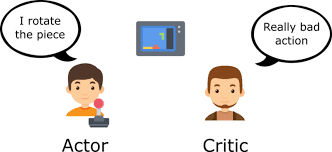

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=24, fc2_units=48):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=24, fc2_units=48):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#**Modelling agent**
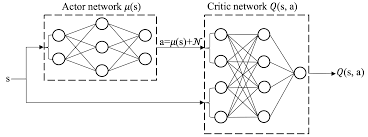

In [ ]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        action = (action + 1.0) / 2.0
        return np.clip(action, 0, 1)


    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#**Some tools that will be useful while simulating Deep RL**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.iolib.table import SimpleTable
from statsmodels.compat.python import zip_longest
from statsmodels.iolib.tableformatting import fmt_2cols


def generate_table(left_col, right_col, table_title):
    
    # Do not use column headers
    col_headers = None
    
    # Generate the right table
    if right_col:
        # Add padding
        if len(right_col) < len(left_col):
            right_col += [(' ', ' ')] * (len(left_col) - len(right_col))
        elif len(right_col) > len(left_col):
            left_col += [(' ', ' ')] * (len(right_col) - len(left_col))
        right_col = [('%-21s' % ('  '+k), v) for k,v in right_col]
        
        # Generate the right table
        gen_stubs_right, gen_data_right = zip_longest(*right_col)
        gen_table_right = SimpleTable(gen_data_right,
                                          col_headers,
                                          gen_stubs_right,
                                          title = table_title,
                                          txt_fmt = fmt_2cols)
    else:
        # If there is no right table set the right table to empty
        gen_table_right = []

    # Generate the left table  
    gen_stubs_left, gen_data_left = zip_longest(*left_col) 
    gen_table_left = SimpleTable(gen_data_left,
                                 col_headers,
                                 gen_stubs_left,
                                 title = table_title,
                                 txt_fmt = fmt_2cols)

    
    # Merge the left and right tables to make a single table
    gen_table_left.extend_right(gen_table_right)
    general_table = gen_table_left

    return general_table


def get_env_param():
    
    # Create a simulation environment
    env = MarketEnvironment()

    # Set the title for the financial parameters table
    fp_title = 'Financial Parameters'

    # Get the default financial parameters from the simulation environment
    fp_left_col = [('Annual Volatility:', ['{:.0f}%'.format(env.anv * 100)]),
                   ('Daily Volatility:', ['{:.1f}%'.format(env.dpv * 100)])]
    
    fp_right_col = [('Bid-Ask Spread:', ['{:.3f}'.format(env.basp)]),
                    ('Daily Trading Volume:', ['{:,.0f}'.format(env.dtv)])]

    # Set the title for the Almgren and Chriss Model parameters table
    acp_title = 'Almgren and Chriss Model Parameters'

    # Get the default Almgren and Chriss Model Parameters from the simulation environment
    acp_left_col = [('Total Number of Shares for Agent1 to Sell:', ['{:,}'.format(env.total_shares1)]),
                    ('Total Number of Shares for Agent2 to Sell:', ['{:,}'.format(env.total_shares2)]),
                    ('Starting Price per Share:', ['${:.2f}'.format(env.startingPrice)]),
                    ('Price Impact for Each 1% of Daily Volume Traded:', ['${}'.format(env.eta)]),                    
                    ('Number of Days to Sell All the Shares:', ['{}'.format(env.liquidation_time)]),
                    ('Number of Trades:', ['{}'.format(env.num_n)])]

    acp_right_col = [('Fixed Cost of Selling per Share:', ['${:.3f}'.format(env.epsilon)]),
                     ('Trader\'s Risk Aversion for Agent 1:', ['{}'.format(env.llambda1)]),
                     ('Trader\'s Risk Aversion for Agent 2:', ['{}'.format(env.llambda2)]),
                     ('Permanent Impact Constant:', ['{}'.format(env.gamma)]),
                     ('Single Step Variance:', ['{:.3f}'.format(env.singleStepVariance)]),
                     ('Time Interval between trades:', ['{}'.format(env.tau)])]

    # Generate tables with the default financial and AC Model parameters
    fp_table = generate_table(fp_left_col, fp_right_col, fp_title)
    acp_table = generate_table(acp_left_col, acp_right_col, acp_title)

    return fp_table, acp_table


def plot_price_model(seed = 0, num_days = 1000):
    
    # Create a simulation environment
    env = MarketEnvironment()

    # Reset the enviroment with the given seed
    env.reset(seed)

    # Create an array to hold the daily stock price for the given number of days
    price_hist = np.zeros(num_days)

    # Get the simulated stock price movement from the environment
    for i in range(num_days):
        _, _, _, info = env.step(i)    
        price_hist[i] = info.price
    
    # Print Average and Standard Deviation in Stock Price
    print('Average Stock Price: ${:,.2f}'.format(price_hist.mean()))
    print('Standard Deviation in Stock Price: ${:,.2f}'.format(price_hist.std()))
#     print('Standard Deviation of Random Noise: {:,.5f}'.format(np.sqrt(env.singleStepVariance * env.tau)))
    
    # Plot the price history for the given number of days
    price_df = pd.DataFrame(data = price_hist,  columns = ['Stock'], dtype = 'float64')
    ax = price_df.plot(colormap = 'cool', grid = False)
    ax.set_facecolor(color = 'k')
    ax = plt.gca()
    yNumFmt = mticker.StrMethodFormatter('${x:,.2f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.ylabel('Stock Price')
    plt.xlabel('days')
    plt.show()
    

    
def get_optimal_vals(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, title = ''):
    
    # Create a simulation environment
    env = MarketEnvironment()

    # Reset the enviroment with the given parameters
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Set the title for the AC Optimal Strategy table
    if title == '':
        title = 'AC Optimal Strategy'
    else:
        title = 'AC Optimal Strategy for ' + title

    # Get the AC optimal values from the environment
    E = env.get_AC_expected_shortfall(env.total_shares)
    V = env.get_AC_variance(env.total_shares)
    U = env.compute_AC_utility(env.total_shares)

    left_col = [('Number of Days to Sell All the Shares:', ['{}'.format(env.liquidation_time)]),
                ('Half-Life of The Trade:', ['{:,.1f}'.format(1 / env.kappa)]),
                ('Utility:', ['${:,.2f}'.format(U)])]

    right_col = [('Initial Portfolio Value:', ['${:,.2f}'.format(env.total_shares * env.startingPrice)]),
                 ('Expected Shortfall:', ['${:,.2f}'.format(E)]),
                 ('Standard Deviation of Shortfall:', ['${:,.2f}'.format(np.sqrt(V))])]

    # Generate the table with the AC optimal values
    val_table = generate_table(left_col, right_col, title)

    return val_table


def get_min_param():
    
    # Get the minimum impact AC parameters
    min_impact = get_optimal_vals(lq_time = 250, nm_trades = 250, tr_risk = 1e-17, title = 'Minimum Impact')
    
    # Get the minimum variance AC parameters
    min_var = get_optimal_vals(lq_time = 1, nm_trades = 1, tr_risk = 0.0058, title = 'Minimum Variance')
    
    return min_impact, min_var
  
            
def get_crfs(trisk):
    
    # Create the annotation label
    tr_st = '{:.0e}'.format(trisk)   
    lnum = tr_st.split('e')[0]   
    lexp = tr_st.split('e')[1]
    if np.abs(np.int(lexp)) < 10:
        lexp = lexp.replace('0', '', 1)    
    an_st = '$\lambda = ' + lnum + ' \\times 10^{' + lexp + '}$'
    
    # Set the correction factors for the annotation label
    if trisk >= 1e-7 and trisk <= 4e-7:
        xcrf = 0.94
        ycrf = 2.5
        scrf = 0.1
    elif trisk > 4e-7 and trisk <= 9e-7:
        xcrf = 0.9
        ycrf = 2.5
        scrf = 0.06
    elif trisk > 9e-7 and trisk <= 1e-6:
        xcrf = 0.85
        ycrf = 2.5
        scrf = 0.06
    elif trisk > 1e-6 and trisk < 2e-6:
        xcrf = 1.2
        ycrf = 2.5
        scrf = 0.06
    elif trisk >= 2e-6 and trisk < 3e-6:
        xcrf = 0.8
        ycrf = 2.5
        scrf = 0.06
    elif trisk >= 3e-6 and trisk < 4e-6:
        xcrf = 0.7
        ycrf = 2.5
        scrf = 0.08
    elif trisk >= 4e-6 and trisk < 7e-6:
        xcrf = 1.4
        ycrf = 2.0
        scrf = 0.08
    elif trisk >= 7e-6 and trisk <= 1e-5:
        xcrf = 4.5
        ycrf = 1.5
        scrf = 0.08
    elif trisk > 1e-5 and trisk <= 2e-5:
        xcrf = 7.0
        ycrf = 1.1
        scrf = 0.08
    elif trisk > 2e-5 and trisk <= 5e-5:
        xcrf = 12.
        ycrf = 1.1
        scrf = 0.08
    elif trisk > 5e-5 and trisk <= 1e-4:
        xcrf = 30
        ycrf = 0.99
        scrf = 0.08
    else:
        xcrf = 1
        ycrf = 1
        scrf = 0.08
    
    return an_st, xcrf, ycrf, scrf
    

def plot_efficient_frontier(tr_risk = 1e-6):
    
    # Create a simulation environment
    env = MarketEnvironment()
    
    # Reset the enviroment with the given trader's risk aversion
    env.reset(lamb = tr_risk)

    # Get the expected shortfall and corresponding variance for the given trader's risk aversion
    tr_E = env.get_AC_expected_shortfall(env.total_shares)
    tr_V = env.get_AC_variance(env.total_shares)
    
    # Create empty arrays to hold our values of E, V, and U
    E = np.array([])
    V = np.array([])
    U = np.array([])
    
    # Set the number of plot points for our frontier
    num_points = 7000
    
    # Set the values of the trader's risk aversion to plot
    lambdas = np.linspace(1e-7, 1e-4, num_points)
    
    # Calclate E, V, U for each value of llambda
    for llambda in lambdas:
        env.reset(lamb = llambda)
        E = np.append(E, env.get_AC_expected_shortfall(env.total_shares))
        V = np.append(V, env.get_AC_variance(env.total_shares))
        U = np.append(U, env.compute_AC_utility(env.total_shares))
        
    # Plot E vs V and use U for the colorbar    
    cm = plt.cm.get_cmap('gist_rainbow')    
    sc = plt.scatter(V, E, s = 20, c = U, cmap = cm)
    plt.colorbar(sc, label = 'AC Utility', format = mticker.StrMethodFormatter('${x:,.0f}'))
    ax = plt.gca()
    ax.set_facecolor('k')
    ymin = E.min() * 0.7
    ymax = E.max() * 1.1
    plt.ylim(ymin, ymax)
    yNumFmt = mticker.StrMethodFormatter('${x:,.0f}')
    xNumFmt = mticker.StrMethodFormatter('{x:,.0f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.xaxis.set_major_formatter(xNumFmt)
    plt.xlabel('Variance of Shortfall')
    plt.ylabel('Expected Shortfall')
    
    # Get the annotation label and the correction factors
    an_st, xcrf, ycrf, scrf = get_crfs(tr_risk)
    
    # Plot the annotation in the above plot
    plt.annotate(an_st, xy = (tr_V, tr_E), xytext = (tr_V * xcrf, tr_E  * ycrf), color = 'w', size = 'large', 
                 arrowprops = dict(facecolor = 'cyan', shrink = scrf, width = 3, headwidth = 10))
    plt.show()
    
    
def round_trade_list(trl):
    
    # Round the shares in the trading list
    trl_rd = np.around(trl)
        
    # Rounding the number of shares in the trading list sometimes results in selling more or less
    # shares than we have available. We calculate the difference between to total number of shares
    # sold in the original trading list and the number of shares sold in the rounded list.
    # This difference will be used to correct for rounding errors. 
    res = np.around(trl.sum() - trl_rd.sum())
        
    # Correct the number of shares sold due to rounding errors if necessary
    if res != 0:
        idx = trl_rd.nonzero()[0][-1]      
        trl_rd[idx] += res
        
    return trl_rd

    
def plot_trade_list(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, show_trl = False):
    
    # Create simulation environment
    env = MarketEnvironment()

    # Reset the environment with the given parameters
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Get the trading list from the environment
    trade_list = env.get_trade_list()
    
    # Add a zero at the beginning of the trade list to indicate that at time 0 we don't sell any stocks
    new_trl = np.insert(trade_list, 0, 0)

    # We create a dataframe with the trading list and trading trajectory
    df = pd.DataFrame(data = list(range(nm_trades + 1)),  columns = ['Trade Number'], dtype = 'float64')
    df['Stocks Sold'] = new_trl
    df['Stocks Remaining'] = (np.ones(nm_trades + 1) * env.total_shares) - np.cumsum(new_trl)

    # Create a figure with 2 plots in 1 row
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    
    # Make a scatter plot of the trade list
    df.iloc[1:].plot.scatter(x = 'Trade Number', y = 'Stocks Sold', c = 'Stocks Sold', colormap = 'gist_rainbow',
                                                 alpha = 1, sharex = False, s = 50, colorbar = False, ax = axes[0])
    
    # Plot a line through the points of the scatter plot of the trade list
    axes[0].plot(df['Trade Number'].iloc[1:], df['Stocks Sold'].iloc[1:], linewidth = 2.0, alpha = 0.5)
    axes[0].set_facecolor(color = 'k')
    yNumFmt = mticker.StrMethodFormatter('{x:,.0f}')
    axes[0].yaxis.set_major_formatter(yNumFmt)
    axes[0].set_title('Trading List')

    # Make a scatter plot of the number of stocks remaining after each trade
    df.plot.scatter(x = 'Trade Number', y = 'Stocks Remaining', c = 'Stocks Remaining', colormap = 'gist_rainbow',
                                                 alpha = 1, sharex = False, s = 50, colorbar = False, ax = axes[1])
    
    # Plot a line through the points of the scatter plot of the number of stocks remaining after each trade
    axes[1].plot(df['Trade Number'], df['Stocks Remaining'], linewidth = 2.0, alpha = 0.5)
    axes[1].set_facecolor(color = 'k')
    yNumFmt = mticker.StrMethodFormatter('{x:,.0f}')
    axes[1].yaxis.set_major_formatter(yNumFmt)
    axes[1].set_title('Trading Trajectory')
    
    # Set the spacing between plots
    plt.subplots_adjust(wspace = 0.4)
    plt.show()
    
    print('\nNumber of Shares Sold: {:,.0f}\n'.format(new_trl.sum()))
    
    if show_trl:
        
        # Since we are not selling fractional shares we round up the shares in the trading list
        rd_trl = round_trade_list(new_trl)
#         rd_trl = new_trl

        # We create a dataframe with the modified trading list and trading trajectory
        df2 = pd.DataFrame(data = list(range(nm_trades + 1)),  columns = ['Trade Number'], dtype = 'float64')
        df2['Stocks Sold'] = rd_trl
        df2['Stocks Remaining'] = (np.ones(nm_trades + 1) * env.total_shares) - np.cumsum(rd_trl)

        return df2.style.hide_index().format({'Trade Number': '{:.0f}', 'Stocks Sold': '{:,.0f}', 'Stocks Remaining': '{:,.0f}'})
#         return df2.style.hide_index().format({'Trade Number': '{:.0f}', 'Stocks Sold': '{:e}', 'Stocks Remaining': '{:e}'})
    

def implement_trade_list(seed = 0, lq_time = 60, nm_trades = 60, tr_risk = 1e-6):
    
    # Create simulation environment
    env = MarketEnvironment()

    # Reset the environment with the given parameters
    env.reset(seed = seed, liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Get the trading list from the environment
    trl = env.get_trade_list()
    
    # Since we are not selling fractional shares we round up the shares in the trading list
    trade_list = round_trade_list(trl)
 
    # set the environment to make transactions
    env.start_transactions()
    
    # Create an array to hold the impacted stock price
    price_hist = np.array([])

    # Implement the trading list in our similation environment
    for trade in trade_list:
        
        # Convert the number of shares to sell in each trade into an action
        action = trade / env.shares_remaining
        
        # Take a step in the environment my selling the number of shares in the current trade
        _, _, _, info = env.step(action)
        
        # Get the impacted price from the environment
        price_hist = np.append(price_hist, info.exec_price)
        
        # If all shares have been sold, stop making transactions and get the implementation sortfall
        if info.done:
            print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
            break

    # Plot the impacted price
    price_df = pd.DataFrame(data = price_hist,  columns = ['Stock'], dtype = 'float64')
    ax = price_df.plot(colormap = 'cool', grid = False)
    ax.set_facecolor(color = 'k')
    ax.set_title('Impacted Stock Price')
    ax = plt.gca()
    yNumFmt = mticker.StrMethodFormatter('${x:,.2f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.plot(price_hist, 'o')
    plt.ylabel('Stock Price')
    plt.xlabel('Trade Number')
    plt.show()


def get_av_std(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, trs = 100):
    
    # Create simulation environment
    env = MarketEnvironment()

    # Reset the enviroment
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Get the trading list
    trl = env.get_trade_list()

    # Since we are not selling fractional shares we round up the shares in the trading list
    trade_list = round_trade_list(trl)

    # Set the initial shortfall to zero
    shortfall_hist = np.array([])

    for episode in range(trs):
        
        # Print current episode every 100 episodes
        if (episode + 1) % 100 == 0:
            print('Episode [{}/{}]'.format(episode + 1, trs), end = '\r', flush = True)
        
        # Reset the enviroment
        env.reset(seed = episode, liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

        # set the environment to make transactions
        env.start_transactions()

        for trade in trade_list:
            action = trade / env.shares_remaining
            _, _, _, info = env.step(action)

            if info.done:
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                break

    print('Average Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.mean()))
    print('Standard Deviation of the Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.std()))
    
    plt.plot(shortfall_hist, 'cyan', label='')
    plt.xlim(0, trs)
    ax = plt.gca()
    ax.set_facecolor('k')
    ax.set_xlabel('Episode', fontsize = 15)
    ax.set_ylabel('Implementation Shortfall (US $)', fontsize = 15)
    ax.axhline(shortfall_hist.mean(),0, 1, color = 'm', label='Average')
    yNumFmt = mticker.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.legend()
    plt.show

In [ ]:
# Get the default financial and AC Model parameters
financial_params, ac_params = get_env_param()

In [ ]:
financial_params


Annual Volatility:,12%,Bid-Ask Spread:,0.125
Daily Volatility:,0.8%,Daily Trading Volume:,"5,000,000"


In [ ]:
ac_params


Total Number of Shares for Agent1 to Sell:,"500,000",Fixed Cost of Selling per Share:,$0.062
Total Number of Shares for Agent2 to Sell:,"500,000",Trader's Risk Aversion for Agent 1:,1e-06
Starting Price per Share:,$50.00,Trader's Risk Aversion for Agent 2:,0.0001
Price Impact for Each 1% of Daily Volume Traded:,$2.5e-06,Permanent Impact Constant:,2.5e-07
Number of Days to Sell All the Shares:,60,Single Step Variance:,0.144
Number of Trades:,60,Time Interval between trades:,1.0


In [ ]:
import numpy as np

import syntheticChrissAlmgren as sca
from ddpg_agent import Agent

from collections import deque

# Create simulation environment
env = MarketEnvironment()

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent1 = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(),random_seed = 1225)
agent2 = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(),random_seed = 108)
# Set the liquidation time
lqt = 60

# Set the number of trades
n_trades = 60

# Set trader's risk aversion
tr1 = 1e-6
tr2 = 1e-6

# Set the number of episodes to run the simulation
episodes = 1300
shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_hist2 = np.array([])
shortfall_deque1 = deque(maxlen=100)
shortfall_deque2 = deque(maxlen=100)
for episode in range(episodes): 
    # Reset the enviroment
    cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1,lamb2 = tr2)

    # set the environment to make transactions
    env.start_transactions()

    for i in range(n_trades + 1):
      
        # Predict the best action for the current state. 
        cur_state1 = np.delete(cur_state,8)
        cur_state2 = np.delete(cur_state,7)
        #print(cur_state[5:])
        action1 = agent1.act(cur_state1, add_noise = True)
        action2 = agent2.act(cur_state2, add_noise = True)
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
        new_state, reward1, reward2, done1, done2, info = env.step(action1,action2)
        
        # current state, action, reward, new state are stored in the experience replay
        new_state1 = np.delete(new_state,8)
        new_state2 = np.delete(new_state,7)
        agent1.step(cur_state1, action1, reward1, new_state1, done1)
        agent2.step(cur_state2, action2, reward2, new_state2, done2)
        # roll over new state
        cur_state = new_state

        if info.done1 and info.done2:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            
            shortfall_hist2 = np.append(shortfall_hist2, info.implementation_shortfall2)
            shortfall_deque2.append(info.implementation_shortfall2)
            break
        
    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque1)))        
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent2: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque2)))
        shortfall_list.append([np.mean(shortfall_deque1),np.mean(shortfall_deque2)])
print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))
print('\nAverage Implementation Shortfall for Agent2: ${:,.2f} \n'.format(np.mean(shortfall_hist2)))

Episode [100/1300]	Average Shortfall for Agent1: $1,168,737.11
Episode [100/1300]	Average Shortfall for Agent2: $1,182,497.01
Episode [200/1300]	Average Shortfall for Agent1: $1,281,250.00
Episode [200/1300]	Average Shortfall for Agent2: $1,281,250.00
Episode [300/1300]	Average Shortfall for Agent1: $1,274,753.90
Episode [300/1300]	Average Shortfall for Agent2: $1,278,818.44
Episode [400/1300]	Average Shortfall for Agent1: $958,446.76
Episode [400/1300]	Average Shortfall for Agent2: $996,403.20
Episode [500/1300]	Average Shortfall for Agent1: $321,537.20
Episode [500/1300]	Average Shortfall for Agent2: $321,944.71
Episode [600/1300]	Average Shortfall for Agent1: $331,625.64
Episode [600/1300]	Average Shortfall for Agent2: $328,738.83
Episode [700/1300]	Average Shortfall for Agent1: $302,789.39
Episode [700/1300]	Average Shortfall for Agent2: $296,596.55
Episode [800/1300]	Average Shortfall for Agent1: $305,151.05
Episode [800/1300]	Average Shortfall for Agent2: $301,542.19
Episode [900

In [ ]:
shortfall = np.array(shortfall_list)

In [ ]:
np.save('1e-6_1e-6_cooporation_shorfall_list.npy',shortfall)

In [ ]:
print(tr1,tr2)
cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1,lamb2 = tr2)

    # set the environment to make transactions
env.start_transactions()

trajectory = np.zeros([n_trades+1,2])
for i in range(n_trades + 1):
    trajectory[i] = cur_state[7:]
    
    print(cur_state[7:])
        # Predict the best action for the current state. 
    cur_state1 = np.delete(cur_state,8)
    cur_state2 = np.delete(cur_state,7)
        #print(cur_state[5:])
    action1 = agent1.act(cur_state1, add_noise = True)
    action2 = agent2.act(cur_state2, add_noise = True)
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
    new_state, reward1, reward2, done1, done2, info = env.step(action1,action2)
        
        # current state, action, reward, new state are stored in the experience replay
    new_state1 = np.delete(new_state,8)
    new_state2 = np.delete(new_state,7)
    agent1.step(cur_state1, action1, reward1, new_state1, done1)
    agent2.step(cur_state2, action2, reward2, new_state2, done2)
        # roll over new state
    cur_state = new_state

    if info.done1 and info.done2:
        shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
        shortfall_deque1.append(info.implementation_shortfall1)
            
        shortfall_hist2 = np.append(shortfall_hist2, info.implementation_shortfall2)
        shortfall_deque2.append(info.implementation_shortfall2)
        break
        
if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
    print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque1)))        
    print('\rEpisode [{}/{}]\tAverage Shortfall for Agent2: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque2)))


1e-06 1e-06
[1. 1.]
[0.761694 0.656324]
[0.603648 0.454928]
[0.44365  0.334226]
[0.305346 0.25539 ]
[0.20247  0.202642]
[0.13316  0.148788]
[0.09197 0.10399]
[0.064072 0.074902]
[0.044238 0.052522]
[0.03257  0.036602]
[0.02397  0.024466]
[0.018556 0.01732 ]
[0.013314 0.011942]
[0.009696 0.008204]
[0.006774 0.005622]
[0.004728 0.003898]
[0.003236 0.002704]
[0.00228  0.001762]
[0.00165 0.00114]
[0.001234 0.000778]
[0.000932 0.000566]
[0.000674 0.000392]
[0.000506 0.00029 ]
[0.000376 0.000212]
[0.000294 0.00015 ]
[0.000224 0.000108]
[1.66e-04 7.40e-05]
[1.14e-04 5.40e-05]
[8.2e-05 4.2e-05]
[5.8e-05 3.4e-05]
[4.0e-05 2.8e-05]
[2.6e-05 2.2e-05]
[1.8e-05 1.8e-05]
[1.2e-05 1.4e-05]
[8.e-06 1.e-05]
[6.e-06 8.e-06]
[4.e-06 6.e-06]
[2.e-06 4.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-06]
[2.e-06 2.e-

In [ ]:
np.save('1e-6_1e-6_competition_trajectory_1500.npy',trajectory)

Helo
Helo


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


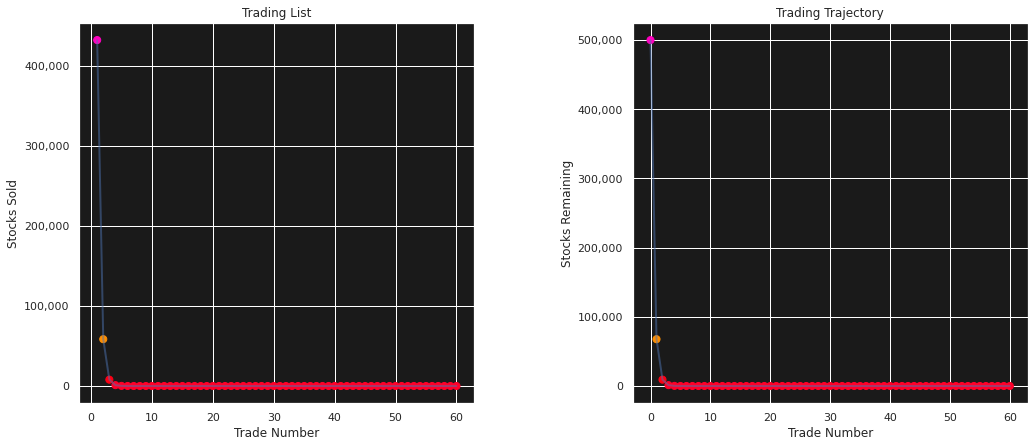


Number of Shares Sold: 500,000



Trade Number,Stocks Sold,Stocks Remaining
0,0,"500,000"
1,"432,332","67,668"
2,"58,510","9,158"
3,"7,918","1,240"
4,"1,072",168
5,145,23
6,20,3
7,3,0
8,0,0
9,0,0


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

import utils

# We set the default figure size
plt.rcParams['figure.figsize'] = [17.0, 7.0]


# Set the number of days to sell all shares (i.e. the liquidation time)
l_time = 60

# Set the number of trades
n_trades = 60

# Set the trader's risk aversion
t1_risk = 1e-6

# Plot the trading list and trading trajectory. If show_trl = True, the data frame containing the values of the
# trading list and trading trajectory is printed
plot_trade_list(lq_time = l_time, nm_trades = n_trades, show_trl = True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('legend',fontsize = 14)

In [ ]:

price_list = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/price_list.npy')

[]

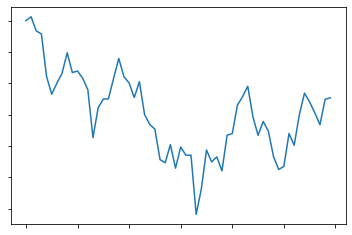

In [ ]:

ax = sns.lineplot(data = price_list)
ax.set_xticklabels(labels = [])
ax.set_yticklabels(labels = [])

In [ ]:
m1_shortfall_list = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_shortfall_list.npy')
m03_shortfall_list = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_shortfall_list_0.3M.npy')
m07_shortfall_list = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_shortfall_list_0.7M.npy')

In [ ]:
E1_list = []
E2_list = []
B1_list = []
B2_list = []
for i in range(len(m1_shortfall_list)):
    E1_list.append(m1_shortfall_list[i])
    E2_list.append(m03_shortfall_list[i]+m07_shortfall_list[i])
    B1_list.append(m03_shortfall_list[i])
    B2_list.append(m07_shortfall_list[i])

In [ ]:

T = np.arange(1,101).tolist()

In [ ]:
df1 = pd.DataFrame()
#df1['Time'] = T
df1['Agent A'] = E1_list
df1['B1+B2'] = E2_list
df1['Agent B1'] = B1_list
df1['Agent B2'] = B2_list

In [ ]:
sns.set()

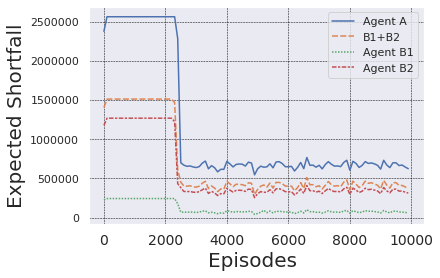

In [ ]:

ax = sns.lineplot(data = df1)
ax.set_ylabel('Expected Shortfall',fontsize = 20)
ax.set_xlabel('Episodes ',fontsize = 20)
ax.set_xticklabels([0,0,2000,4000,6000,8000,10000],fontsize = 14)
ax.grid(b=True, which='major', color='black', linewidth=0.5,linestyle = '--')

In [ ]:
A1 = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-4_optimal.npy')
A2 = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-9_optimal.npy')
B = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-4_1e-9_trajectory.npy')

In [ ]:
A1_list = []
A2_list = []
B1_list = []
B2_list = []
for i in range(len(A1)):
    A1_list.append(A1[i])
    A2_list.append(A2[i])
    B1_list.append(B[i][0])
    B2_list.append(B[i][1])

In [ ]:

df2 = pd.DataFrame()
#df1['Time'] = T
df2['Agent A1'] = A1_list
df2['Agent A2'] = A2_list
df2['Agent B1'] = B1_list
df2['Agent B2'] = B2_list

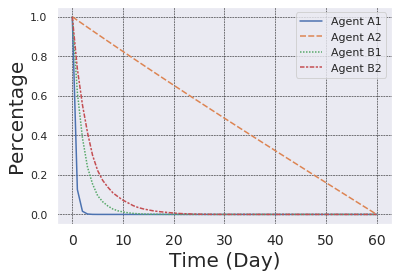

In [ ]:
ax = sns.lineplot(data = df2)
ax.set_ylabel('Percentage',fontsize = 20)
ax.set_xlabel('Time (Day)',fontsize = 20)
ax.set_xticklabels([0,0,10,20,30,40,50,60], fontsize = 14)
ax.grid(b=True, which='major', color='black', linewidth=0.5,linestyle = '--')

In [ ]:
A = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_shortfall_list.npy')
B = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_1e-6_competition_shortfall_list.npy')
C = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_1e-6_cooporation_shortfall_list.npy')

In [ ]:

A_list = []
B_list = []
C_list = []
for i in range(len(A)):
    A_list.append(A[i])
    B_list.append(B[i].sum())
    C_list.append(C[i].sum())

In [ ]:
df3 = pd.DataFrame()
df3['Independent'] = A_list
df3['Competitive'] = B_list
df3['Cooporative'] = C_list

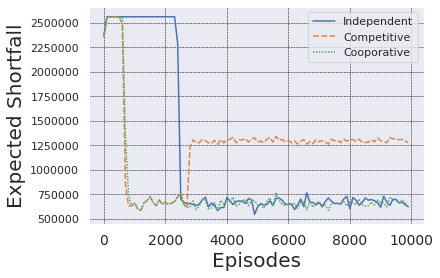

In [ ]:

ax = sns.lineplot(data = df3)
ax.set_ylabel('Expected Shortfall',fontsize = 20)
ax.set_xlabel('Episodes',fontsize = 20)
ax.set_xticklabels([0,0,2000,4000,6000,8000,10000],fontsize = 14)
ax.grid(b=True, which='major', color='black', linewidth=0.5,linestyle = '--')

In [ ]:

A = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_optimal.npy')
B = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_trajectory_fixed_competitor.npy')

In [ ]:
B = np.zeros(61)

In [ ]:
B[0:2] = np.load('/content/Multi-Agent-RL-for-Liquidation/Results/1e-6_trajectory_fixed_competitor.npy')

In [ ]:
A_list = []
B_list = []
for i in range(len(A)):
    A_list.append(A[i])
    B_list.append(B[i])

In [ ]:
df4 = pd.DataFrame()
df4['Independent'] = A_list
df4['With Competitor'] = B_list

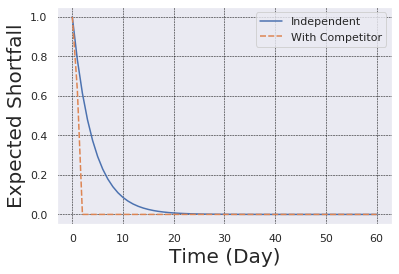

In [ ]:
ax = sns.lineplot(data = df4)
ax.set_ylabel('Expected Shortfall',fontsize = 20)
ax.set_xlabel('Time (Day)',fontsize = 20)
ax.grid(b=True, which='major', color='black', linewidth=0.5,linestyle = '--')